In [14]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns

# Reservoir model

Задача - построить 2D модель резервуара. Для начала необходимо задать свойства полости, такие как $\phi,\ S_{water}, S_{oil} = 1 - S_{water}, c_r, c$. Также величины, фигурирующие в законе Дарси: $k, \mu, \rho$. Будем считать модель изотропной и варьировать лишь $S_{oil}$

## Построение формы резервуара
Будем задавать значения каким -нибудь рандомным способом, но красивым. В `sklearn` есть множество методов создания выборок для классификации, мне понравился этот. Так мы и будем определять где вода, а где нефть.

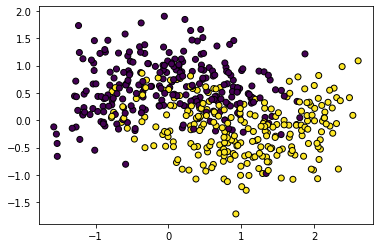

In [125]:
ds = make_moons(n_samples=500, noise=0.4, random_state=0)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()          

Перенесём всё это на меньший сетку фиксированного размера c фиксированным шагом по следующим правилам
<ol>
<li>Если в ячейке не оказывается ни одного элемента - значит это не пористая структура.

<li>Если оказывается несколько - берёс среднее арифметическое
</ol>

In [126]:
n_x, n_y = 25, 25
x_max, x_min = 2, -2
y_max, y_min = 2, -2

In [127]:
xs = np.linspace(x_min, x_max, n_x+1)
ys = np.linspace(y_min, y_max, n_y+1)
Satur_matrix = (-1) * np.ones((n_x, n_y))

for ix in range(len(xs)-1):
    for iy in range(len(ys)-1):
        x_filt = (ds[0][:, 0] > xs[ix]) & (ds[0][:, 0] < xs[ix+1])
        y_filt = (ds[0][:, 1] > ys[iy]) & (ds[0][:, 1] < ys[iy+1])
        filt = (y_filt & x_filt)
        if filt.sum() > 0:
            Satur_matrix[ix][iy] = ds[1][x_filt & y_filt].mean()
        

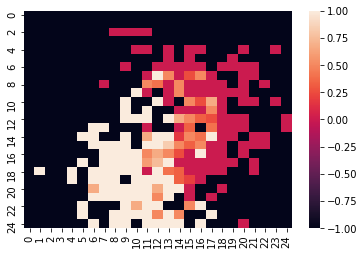

In [128]:
sns.heatmap(Satur_matrix)
plt.show()